In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

# Добрият, лошият и алгоритъмът

### Преглед на концепцията за GAN мрежи и публикацията, с която те се появиха в научния свят




## Резюме

<b> Генеративните състезателни мрежи, Generative Adversarial Networks, или просто GAN, </b> са сред най-модерните концепции в света на машинното самообучение и дълбоките невронни мрежи.

Историята на GAN, научното им значение и бъдещите перспективи пред тях са събрани в [журналистически материал, който предстои да бъде публикуван](https://docs.google.com/document/d/1uSN62kxxQL-MAvRxq_pys0PIxxJKqvbxtLVqpydSFZg/edit?usp=sharing) на сайта „Дигитални истории“.

Научната публикация на Йън Гудфелоу и колегите му от 2014-а може да бъде намерена [тук](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf). 

## Проблемът

<b> Дълбоките невронни мрежи </b>, както и обичайните алгоритми от света на машинното самообучение, винаги имат едно от двете възможни предназначения – класификация или прогнозиране. 

Следващата стъпка от развитието им, предложена в тази фундаментална днес научна публикация от Гудфелоу и колегите му, обединява двете направления. В нея успоредно работят две невронни мрежи, които се допълват по начин, който се оказва изключително успешен там, където целта е резултатът да е неразличим с някоя от единиците в изходните данни и същевременно да не ги повтаря.

Генераторът се старае да създава максимално подобни копия, работейки чрез прогнозиране, докато дискриминаторът се опитва да съпостави резултатите с началните данни и дотхвърля тези, които не покриват нужните критерии. Тоест, отговаря за класификацията.

## Публикацията


Гудфелоу и колегите му използват двете класически решения в областта на невронните мрежи, като доказват чрез убедителни примери, че това води до очакваните резултати. 

Прилагат ги при лица, ръкописни числа, произведения на изкуството, като в резултат получават убедителни резултати, сходни с първоначалните. 

## Имплементация

Възможно най-елементарният GAN е създаден по примера, даден в списъка с чести приложения на TensorFlow.

### Подготовка на данните

Използва се класическата колекция MNIST, генераторът ще се опитва да генерира написани да ръка цифри, които максимално да напомнят тези от данните. 

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Създаване на моделите

Генераторът и дискриминаторът са създадени с помощта на модели от Keras. 

### Генератор


In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Генераторът създава случаен шум, който след преминаването си през невронната мрежа трябва да наподобява входните образи.

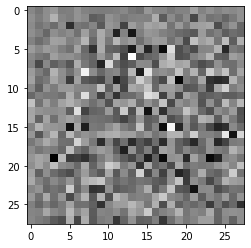

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Дискриминатор

Дискриминаторът е класификатор на изображения, базиран на конволюционни невронни мрежи.


In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Дискриминаторът се използва, за да класифицира получените изображения, като истински или фалшиви. Моделът дава положителна или отрицателна оценка за съответния набор данни.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0013623]], shape=(1, 1), dtype=float32)


## Loss функции и оптимизации


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Трениране на данните

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Двете невронни мрежи се тренират независимо една от друга. 

Зададени са 50 епохи.

При тренирането генераторът получава като входни данни случаен набор, който се използва, за да се създаде изображение. След това дискриминаторът класифицира реалните изображения и тези, получени от генератора.

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Генериране и запазване на изображенията

In [18]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Трениране на модела


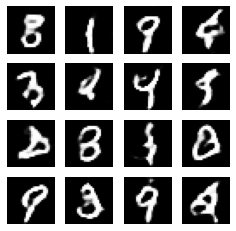

In [19]:
train(train_dataset, EPOCHS)

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Създаване на GIF изображение с резултата от всяка от епохите


In [21]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


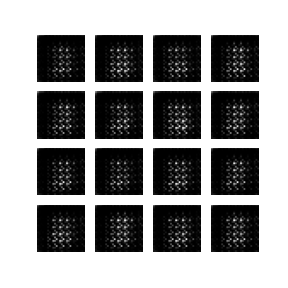

In [22]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)